<h1><center><font size="25">Comparación métodos de <i>forecasting</i> con skforecast</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>Mayo, 2021</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Forecasting series temporales con Python y Scikit Learn](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)

+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)

## Caso de uso
<br>

Se dispone de una serie temporal con la demanda eléctrica (MW) del estado de Victoria (Australia) desde 2011-12-31 al 2014-12-31. Se pretende generar un modelo de *forecasting* capaz de predecir la demanda energética del día siguiente a nivel horario. 

Se comparan las entrategias *recursive multi-step forecasting* y *direct multi-step forecasting* disponibles en la librería [**skforecast**](https://github.com/JoaquinAmatRodrigo/skforecast).
<br>

## Librerías
<br>

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8.1
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from skranger.ensemble import RangerForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg

#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import time_series_spliter
#from skforecast.model_selection import cv_forecaster
#from skforecast.model_selection import backtesting_forecaster

from skforecast.experimental.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.experimental.model_selection import grid_search_forecaster
from skforecast.experimental.model_selection import time_series_spliter
from skforecast.experimental.model_selection import cv_forecaster
from skforecast.experimental.model_selection import backtesting_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos
<br>

In [2]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'
datos = pd.read_csv(url, sep=',')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [3]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq=''30min'', fill_value=np.nan)

True

In [4]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,True
2011-12-31 15:00:00,3963.264688,20.625,True
2011-12-31 16:00:00,3950.913495,20.325,True
2011-12-31 17:00:00,3627.860675,19.850,True
2011-12-31 18:00:00,3396.251676,19.025,True
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,False
2014-12-31 10:00:00,3909.230704,20.300,False
2014-12-31 11:00:00,3900.600901,19.650,False


Para el modelado, se utilizan los datos desde *2013-01-01 14:00:00* hasta el *2014-12-30 23:00:00*.

In [5]:
# Separación datos train-validation-test
# ==============================================================================
dias_test = 90
datos     = datos.loc['2013-01-01 00:00:00': '2014-12-30 23:00:00']
fecha_fin_train   = (datos.index[-1] - pd.Timedelta(dias_test, unit='D'))
fecha_inicio_test = fecha_fin_train + pd.Timedelta(1, unit='H')
datos = datos.Demand
datos_train = datos.loc[: fecha_fin_train]
datos_test  = datos.loc[fecha_inicio_test:]

print(f"Fechas train: {datos_train.index.min()} --- {datos_train.index.max()}")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}")

Fechas train: 2013-01-01 00:00:00 --- 2014-10-01 23:00:00
Fechas test : 2014-10-02 00:00:00 --- 2014-12-30 23:00:00


Para los procesos de *grid search*, se entrenan los modelos hasta '2014-04-31 23:00:00'.

## Exploración gráfica
<br>

**Serie temporal completa**

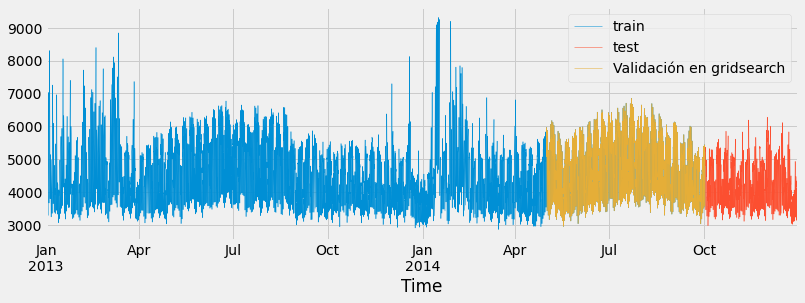

In [6]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.plot(ax=ax, label='train', linewidth=0.5)
datos_test.plot(ax=ax, label='test', linewidth=0.5)
datos_train['2014-04-30 23:00:00':datos_train.index.max()]\
    .plot(ax=ax, label='Validación en gridsearch', linewidth=0.5)
ax.legend();

## Modelo autoregresivo recursivo

In [7]:
# Data frame para almacenar el error de cada tipo de modelo
resultados_modelos = pd.DataFrame(columns=['modelo', 'error_backtest'])

### Modelo lineal

In [8]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(normalize=True),
                    lags      = 12 # Este valor será remplazado en el grid search
              )

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags utilizados como predictores
lags_grid = [[1, 2, 23, 24, 25], [1, 2, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        method      = 'backtesting',
                        metric      = 'mean_absolute_error',
                        initial_train_size    = len(datos_train[:'2014-04-30 23:00:00']),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-07-26 23:44:13,949 root       INFO  Number of models to fit: 20
loop lags_grid: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]   
2021-07-26 23:44:20,413 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2 23 24 25 47 48 49] 
params: {'alpha': 0.021544346900318832}



Number of observations used for training: 15336
Number of observations used for testing: 2160
    Number of folds: 90
    Number of steps per fold: 24


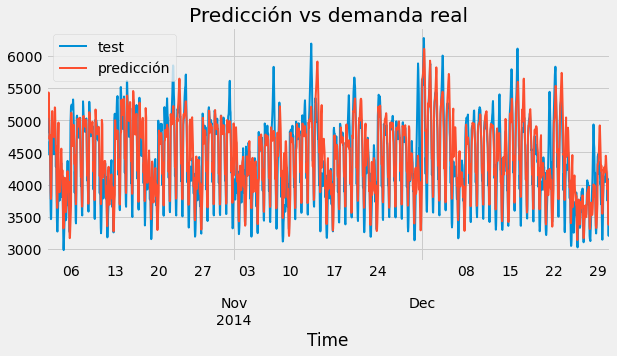

In [9]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

fig, ax = plt.subplots(figsize=(9, 4))
datos_test.loc[predicciones.index].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [10]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')
resultados_modelos = resultados_modelos.append(
                        {'modelo': 'autoreg recursivo lineal',
                         'error_backtest': metrica[0]},
                        ignore_index=True
                     )

Error backtest: [249.30596897]


### Modelo random forest

In [11]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RangerForestRegressor(seed=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [[1, 2, 23, 24, 25], [1, 2, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        method      = 'backtesting',
                        metric      = 'mean_squared_error',
                        initial_train_size    = len(datos_train[:'2014-04-30 23:00:00']),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-07-26 23:44:21,172 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 2/2 [07:53<00:00, 236.97s/it]
2021-07-26 23:52:15,110 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2 23 24 25] 
params: {'max_depth': 10, 'n_estimators': 500}



Number of observations used for training: 15336
Number of observations used for testing: 2160
    Number of folds: 90
    Number of steps per fold: 24


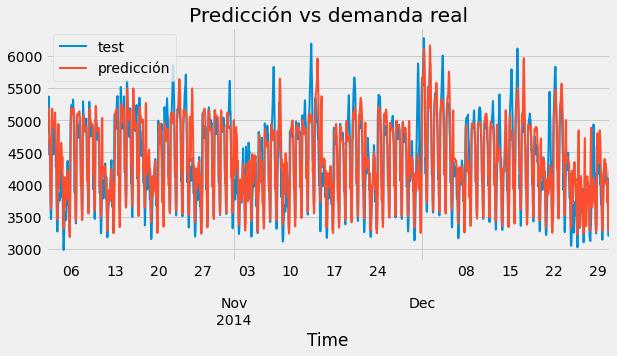

In [12]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

fig, ax = plt.subplots(figsize=(9, 4))
datos_test.loc[predicciones.index].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [13]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

resultados_modelos = resultados_modelos.append(
                        {'modelo': 'autoreg recursivo random forest',
                         'error_backtest': metrica[0]},
                        ignore_index=True
                     )

Error backtest: [239.2227685]


### Modelo XGBoost

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [500, 1000],
              'max_depth': [5, 10],
              'learning_rate': [0.01, 0.1]}

# Lags utilizados como predictores
lags_grid = [[1, 2, 23, 24, 25], [1, 2, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        method      = 'backtesting',
                        metric      = 'mean_squared_error',
                        initial_train_size    = len(datos_train[:'2014-04-30 23:00:00']),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-07-26 23:53:53,727 root       INFO  Number of models to fit: 16
loop param_grid:  88%|████████▊ | 7/8 [00:42<00:06,  6.48s/it]

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

fig, ax = plt.subplots(figsize=(9, 4))
datos_test.loc[predicciones.index].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

resultados_modelos = resultados_modelos.append(
                        {'modelo': 'autoreg recursivo xgboost',
                         'error_backtest': metrica[0]},
                        ignore_index=True
                     )

## Modelo autoregresivo multioutput

### Modelo lineal

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(normalize=True),
                    steps     = 24,
                    lags      = 12 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags utilizados como predictores
lags_grid = [[1, 2, 23, 24, 25], [1, 2, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        method      = 'backtesting',
                        metric      = 'mean_squared_error',
                        initial_train_size    = len(datos_train[:'2014-04-30 23:00:00']),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                  )

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)


fig, ax = plt.subplots(figsize=(9, 4))
datos_test.loc[predicciones.index].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

resultados_modelos = resultados_modelos.append(
                        {'modelo': 'autoreg multioutput lineal',
                         'error_backtest': metrica[0]},
                        ignore_index=True
                     )

### Modelo random forest (skranger)

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RangerForestRegressor(seed=123),
                    steps     = 24,
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [[1, 2, 23, 24, 25], [1, 2, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        method      = 'backtesting',
                        metric      = 'mean_squared_error',
                        initial_train_size    = len(datos_train[:'2014-04-30 23:00:00']),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                  )

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)


fig, ax = plt.subplots(figsize=(9, 4))
datos_test.loc[predicciones.index].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

resultados_modelos = resultados_modelos.append(
                        {'modelo': 'autoreg multioutput random forest',
                         'error_backtest': metrica[0]},
                        ignore_index=True
                     )

### Modelo XGBoost

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = XGBRegressor(random_state=123),
                    steps     = 24,
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [500, 1000],
              'max_depth': [5, 10],
              'learning_rate': [0.01, 0.1]}

# Lags utilizados como predictores
lags_grid = [[1, 2, 23, 24, 25], [1, 2, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        method      = 'backtesting',
                        metric      = 'mean_squared_error',
                        initial_train_size    = len(datos_train[:'2014-04-30 23:00:00']),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                  )

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)


fig, ax = plt.subplots(figsize=(9, 4))
datos_test.loc[predicciones.index].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

resultados_modelos = resultados_modelos.append(
                        {'modelo': 'autoreg multioutput xgboost',
                         'error_backtest': metrica[0]},
                        ignore_index=True
                     )

## Añadir variables exógenas
<br>

Véase cómo afecta al modelo si se incluye como predictor la variable Holiday disponible en el set de datos.

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'
datos = pd.read_csv(url, sep=',')

# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos['Holiday'] = datos['Holiday'].astype(int)

# División train-test
# ==============================================================================
dias_test = 100
datos     = datos.loc['2013-01-01 00:00:00': '2014-12-30 23:00:00']
fecha_fin_train   = (datos.index[-1] - pd.Timedelta(dias_test, unit='D'))
fecha_inicio_test = fecha_fin_train + pd.Timedelta(1, unit='H')
datos_train = datos.loc[: fecha_fin_train]
datos_test  = datos.loc[fecha_inicio_test:]

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
regressor = XGBRegressor(learning_rate= 0.1, max_depth= 5, n_estimators= 500)
forecaster = ForecasterAutoregMultiOutput(
                    regressor = regressor,
                    lags      = [1, 2, 23, 24, 25],
                    steps     = 24
             )
forecaster

In [ ]:
backtesting_forecaster(
    forecaster = forecaster,
    y          = datos.Demand,
    exog       = datos.Holiday,
    initial_train_size = datos_train.shape[0],
    steps      = 24,
    metric     = 'mean_absolute_error',
    verbose    = True
)

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            exog       = datos.Holiday,
                            initial_train_size = datos_train.shape[0],
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index[:len(predicciones)])


fig, ax = plt.subplots(figsize=(9, 4))
datos_test.Demand.loc[predicciones.index].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

resultados_modelos = resultados_modelos.append(
                        {'modelo': 'autoreg multioutput xgboost + exog',
                         'error_backtest': metrica[0]},
                        ignore_index=True
                     )

## Resultados por modelo

In [ ]:
resultados_modelos.sort_values(by='error_backtest')

## Información de sesión

In [ ]:
import session_info
session_info.show()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.